In [1]:
using Pkg
Pkg.activate()

import Pkg
Pkg.add(path="/home/harsh/Work/code/KadanoffBaym.jl")
include("/home/harsh/Work/code/KadanoffBaym.jl")
#import KandaoffBaym
using KadanoffBaym

using LinearAlgebra
#Pkg.update(LinearAlgebra)

Pkg.add("BlockArrays")
using BlockArrays

#Pkg.add("ChainRulesCore")
using ChainRulesCore

using Distributions
#Pkg.add("Distributions")

#Pkg.add("PyPlot")
using PyPlot

#Pkg.build("PyCall")

  Activating project at `~/.julia/environments/v1.8`
    Updating git-repo `/net/theorie/home/harsh/Work/code/KadanoffBaym.jl`
    Updating registry at `~/.julia/registries/General`
    Updating git-repo `https://github.com/JuliaRegistries/General.git`
   Resolving package versions...
  No Changes to `/net/theorie/home/harsh/.julia/environments/v1.8/Project.toml`
  No Changes to `/net/theorie/home/harsh/.julia/environments/v1.8/Manifest.toml`
   Resolving package versions...
  No Changes to `/net/theorie/home/harsh/.julia/environments/v1.8/Project.toml`
  No Changes to `/net/theorie/home/harsh/.julia/environments/v1.8/Manifest.toml`


In [2]:
"""
    Response

Defined as 
`` G(t,t') = 0 if t' > t ``
"""
struct Response <: KadanoffBaym.AbstractSymmetry end

@inline KadanoffBaym.symmetry(::Type{Response}) = zero


In [3]:
# Setting up the reactions and the parameters:

num_species     = 3 #Number of species in the reaction system
num_interaction = 1 # Number of interating reactions in the Hamiltonian
num_reactions   = 2*num_species + num_interaction # This counts the total number of possible reactions in the system.
                                        # We have 2N creation and destruction reactions and the rest interaction reactions
# k1,A = 8, k2,A = 3, k1,B =8, k2,B =2, k1,C =3, k2,C =1.5 and k3 =0.5.

# Rate constants for the reaction system: [k1 is Creation and k2 is Destruction]
k1 = [4.,4.,3.] #len must be equal to num_species
k2 = [3.,2.,3.] #len must be equal to num_species

k3 = [1.]

initial_values = k1./k2

3-element Vector{Float64}:
 1.3333333333333333
 2.0
 1.0

In [4]:
#Parameters simulation
tmax = 0.1
atol = 1e-5
rtol = 1e-3
tstart = 0.;

In [18]:
dim  = num_species

#Why define it as dim*dim,  can simply be only dim!!

resp_gf_MF = GreenFunction(zeros(Float64, dim, 1, 1),Response)
mu_MF      = GreenFunction(zeros(Float64, dim, 1), OnePoint)
sigma_MF   = zero(resp_gf_MF)

resp_gf_MF[:,1, 1] = ones(dim);
mu_MF[:,1]         = initial_values;

In [34]:
function fv!(resp_gf, mu, sigma, out, times, h1, h2, t, t′)
    
    temp    = zero(resp_gf[t,t′])
    temp[1] = -k2[1]*resp_gf[1,t,t′] -k3[1]*mu[2,t]*resp_gf[1,t,t′]
    temp[2] = -k2[2]*resp_gf[2,t,t′] -k3[1]*mu[1,t]*resp_gf[2,t,t′]
    temp[3] = -k2[3]*resp_gf[3,t,t′]
    out[1]  .= temp
    
end

#Diagonal evolution
function fd!(resp_gf, mu, sigma, out, times, h1, h2, t, t′)
    
    out[1] = zero(out[1])
end

# one-time equation for condensate amplitude
function f1!(resp_gf, mu, sigma, out, times, h1, t)
    
    temp = zeros(3)
    
    temp[1] = k1[1] - k2[1]*mu[1,t] -k3[1]*mu[1,t]*mu[2,t]
    temp[2] = k1[2] - k2[2]*mu[2,t] -k3[1]*mu[1,t]*mu[2,t]
    temp[3] = k1[3] - k2[3]*mu[3,t] +k3[1]*mu[1,t]*mu[2,t]
    
    out[1] .= temp
    
    #print(out)

end

f1! (generic function with 1 method)

In [35]:
@time sol_MF = kbsolve!(
    (x...) -> fv!(resp_gf_MF, mu_MF, sigma_MF, x...),
    (x...) -> fd!(resp_gf_MF, mu_MF, sigma_MF, x...),
    [resp_gf_MF],
    (0.0, tmax);
    atol = atol,
    rtol = rtol,
    stop = x -> (println("t: $(x[end])"); flush(stdout); false),
    v0 = [mu_MF,],
    f1! = (x...) -> f1!(resp_gf_MF, mu_MF, sigma_MF, x...)
);

t: 0.0
t: 1.0e-6
t: 5.999999999999999e-6
t: 2.249322749330604e-5
t: 6.754752877849986e-5
t: 0.00021622377214516587
t: 0.0003500323911751653
t: 0.0004704601483021648
t: 0.0005788451297164643
t: 0.0006763916129893338
t: 0.0007641834479349164
t: 0.0008431960993859406
t: 0.0009143074856918624
t: 0.0009783077333671922
t: 0.0010907364278409987
t: 0.0012787013660038042
t: 0.0015708856956138512
t: 0.0019209618528816161
t: 0.0023055183084588187
t: 0.0028082024666255074
t: 0.0036146330210924077
t: 0.004881927906041857
t: 0.0067631955969827936
t: 0.009360607819516547
t: 0.013065300831994909
t: 0.018039346831195242
t: 0.02440291986438437
t: 0.03222455525002444
t: 0.041586849750984776
t: 0.05255091830419081
t: 0.06512787890458303
t: 0.07928858287316423
t: 0.09498205863254916
  1.605388 seconds (2.13 M allocations: 101.929 MiB, 1.71% gc time, 99.28% compilation time)


In [38]:
#touch("data/momentClosure/MM1_KM_scaleSubstrate_2/alpha_"*string(i)*".csv")
using DelimitedFiles

touch("/home/harsh/Work/code/KadanoffBaym.jl/data/ABC_MF.csv")

abc = open("/home/harsh/Work/code/KadanoffBaym.jl/data/ABC_MF.csv", "w")
mn = convert(Array,mu_MF[:])
    
writedlm(abc, vcat(transpose(sol_MF.t),(mn))) 
close(abc)

print("done")

done

In [43]:
#touch("data/momentClosure/MM1_KM_scaleSubstrate_2/alpha_"*string(i)*".csv")
using DelimitedFiles

touch("/home/harsh/Work/code/KadanoffBaym.jl/data/ABC_MF_resp.csv")

abc = open("/home/harsh/Work/code/KadanoffBaym.jl/data/ABC_MF_resp.csv", "w")
mn = convert(Array,resp_gf_MF[:,:,:])
    
writedlm(abc,mn)#, vcat(transpose(sol_MF.t),(mn))) 
close(abc)

print("done")

done

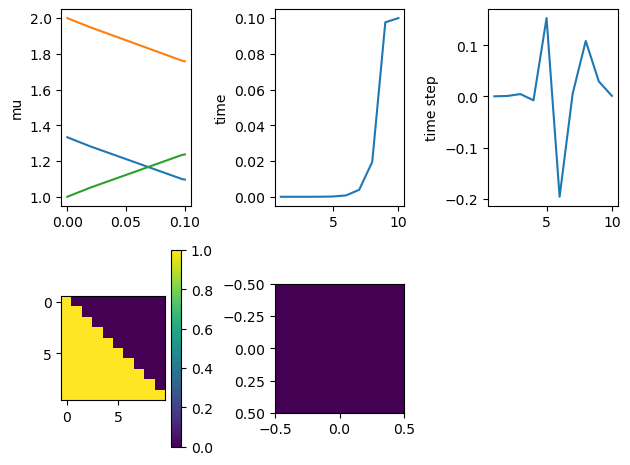

In [8]:
subplot(231)
plot(sol_MF.t, mu_MF[1,:])
plot(sol_MF.t, mu_MF[2,:])
plot(sol_MF.t, mu_MF[3,:])
ylabel("mu")

subplot(232)
plot(1:length(sol_MF.t),sol_MF.t)
ylabel("time")

subplot(233)
plot(1:length(sol_MF.t),sol_MF.w[length(sol_MF.t)])
ylabel("time step")

subplot(234)
imshow(resp_gf_MF[1,:,:])
colorbar()

subplot(235)
imshow(sigma_MF[1,:,:])

tight_layout()

## Add the first non-trivial correction and then solve:

Need to define a function which calculates the self-energy, one that calculates the integral, and finally one that gives the time update:

In [44]:
#Initialization
dim            = num_species
resp_gf_alpha2 = GreenFunction(zeros(Float64, dim, 1,1), Response)
mu_alpha2      = GreenFunction(zeros(Float64, dim,1), OnePoint)
sigma_alpha2   = zero(resp_gf_alpha2)

resp_gf_alpha2[:,1, 1] = ones(dim);
mu_alpha2[:,1]         = initial_values;

In [45]:
# Callback function for the self-energies
function self_energy_alpha2!(resp_gf, mu, sigma, times, h1, h2 , t, t′)
        
    # Resize self-energies when Green functions are resized    
    if (n = size(resp_gf, 2)) > size(sigma, 2)
        resize!(sigma, n)
    end
    
    sigma[1,t,t′] = (resp_gf[1,:,:].*resp_gf[2,:,:])[t,t′]
    sigma[2,t,t′] = (resp_gf[1,:,:].*resp_gf[2,:,:])[t,t′]
    #sigma[3,t,t′] = -(resp_gf[1,:,:].*resp_gf[2,:,:])[t,t′]
    
    #Different self-energies for mu and for Resp when only considering single species responses!
    
end

self_energy_alpha2! (generic function with 1 method)

In [46]:
# Right-hand side for the "vertical" evolution
function fv!(resp_gf, mu, sigma, out, times, h1, h2, t, t′)
    
    temp    = zero(resp_gf[t,t′])
    corr    = integrate2(h1, t, t′, sigma, resp_gf, mu)
    
    temp[1] = -k2[1]*resp_gf[1,t,t′] -k3[1]*mu[2,t]*resp_gf[1,t,t′]
    temp[2] = -k2[2]*resp_gf[2,t,t′] -k3[1]*mu[1,t]*resp_gf[2,t,t′]
    temp[3] = -k2[3]*resp_gf[3,t,t′]
    
    out[1]  .= temp .+ k3[1]^2 .*corr
    #out[1][1] = -k2[1]*resp_gf[1,t,t′] -2*k3*mu[t]*resp_gf[t,t′] +4*k3^2*integrate2(h1, t, t′, sigma, resp_gf, mu)
    #return out
    
end

#diagonal evolution
function fd!(resp_gf, mu, sigma, out, times, h1, h2, t, t′)
    out[1] = zero(out[1])
end

# one-time equation for condensate amplitude
function f1!(resp_gf, mu, sigma, out, times, h1, t)
    
    temp      = zero(mu[t])
    corr      = integrate1(h1, t, sigma, mu)
    
    temp[1] = k1[1] .- k2[1].*mu[1,t] .-k3[1].*mu[1,t].*mu[2,t]
    temp[2] = k1[2] .- k2[2].*mu[2,t] .-k3[1].*mu[1,t].*mu[2,t]
    temp[3] = k1[3] .- k2[3].*mu[3,t] .+k3[1].*mu[1,t].*mu[2,t]
    
    out[1]    .= temp .+ k3[1]^2 .*corr
    
end

f1! (generic function with 1 method)

In [51]:
function integrate1(hs::Vector, t1, Σ::GreenFunction, μ::GreenFunction; tmax=t1)
    retval = zero(μ[t1])
    
    for k in 1:tmax
        retval[1] += Σ[1,t1,k]*μ[1,k]*μ[2,k]*hs[k]
        retval[2] += Σ[2,t1,k]*μ[1,k]*μ[2,k]*hs[k]
        retval[3] += -Σ[2,t1,k]*μ[1,k]*μ[2,k]*hs[k]
        
    end
    return retval
end

function integrate2(hs::Vector, t1, t2, Σ::GreenFunction, R::GreenFunction, μ::GreenFunction; tmax=t1)
    
    retval = zero(R[t1,t2])

    for k in t2:t1
        retval[1] += Σ[1,t1,k].*μ[2,k]*R[1,k,t2]*hs[k]
        retval[2] += Σ[2,t1,k].*μ[1,k]*R[2,k,t2]*hs[k]
    end
    
    return retval
end

integrate2 (generic function with 1 method)

In [48]:
@time sol_alpha2 = kbsolve!(
    (x...) -> fv!(resp_gf_alpha2, mu_alpha2, sigma_alpha2, x...),
    (x...) -> fd!(resp_gf_alpha2, mu_alpha2, sigma_alpha2, x...),
    [resp_gf_alpha2],
    (0.0, tmax);
    callback = (x...) -> self_energy_alpha2!(resp_gf_alpha2, mu_alpha2, sigma_alpha2, x...),
    atol = atol,
    rtol = rtol,
    stop = x -> (println("t: $(x[end])"); flush(stdout); false),
    v0 = [mu_alpha2,],
    f1! = (x...) -> f1!(resp_gf_alpha2, mu_alpha2, sigma_alpha2, x...)
);

t: 0.0
t: 1.0e-6
t: 5.999999999999999e-6
t: 2.2493231453509458e-5
t: 6.754751187160101e-5
t: 0.00021622374528309458
t: 0.00035003235535343874
t: 0.0004704601044167485
t: 0.0005788450785737273
t: 0.0006763915553150082
t: 0.000764183384382161
t: 0.0008431960305425984
t: 0.0009143074120869922
t: 0.0009783076554769465
t: 0.0010907357703199394
t: 0.0012786802967873889
t: 0.0015689615755999416
t: 0.0019148825688648484
t: 0.002293935923947325
t: 0.0027882664085687207
t: 0.0035792788129252106
t: 0.0048142105292844715
t: 0.006647135851231902
t: 0.009167025688194151
t: 0.012768378989842006
t: 0.017601533414028044
t: 0.02377550605309727
t: 0.031361537183541156
t: 0.04044145636504732
t: 0.0510794506431209
t: 0.06328913711770894
t: 0.07704501918805946
t: 0.09230174552240303
  2.353742 seconds (3.28 M allocations: 306.140 MiB, 2.42% gc time, 94.78% compilation time)


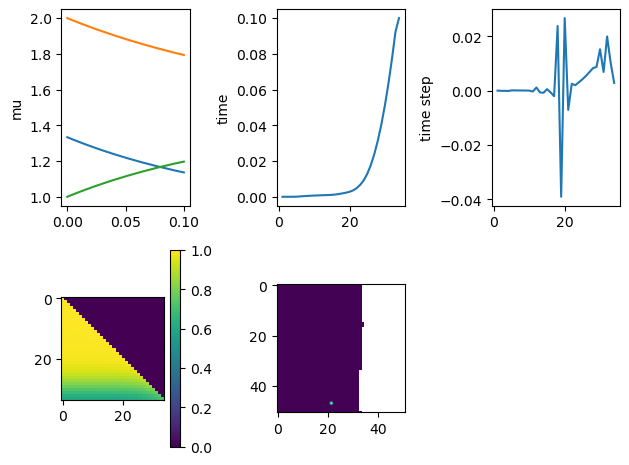

/usr/lib64/python3.11/site-packages/matplotlib/image.py:455: RuntimeWarning: overflow encountered in scalar multiply
  newmin = vmid - dv * fact
/usr/lib64/python3.11/site-packages/matplotlib/image.py:460: RuntimeWarning: overflow encountered in scalar multiply
  newmax = vmid + dv * fact


In [49]:
subplot(231)
plot(sol_alpha2.t, mu_alpha2[1,:])
plot(sol_alpha2.t, mu_alpha2[2,:])
plot(sol_alpha2.t, mu_alpha2[3,:])
ylabel("mu")

subplot(232)
plot(1:length(sol_alpha2.t),sol_alpha2.t)
ylabel("time")

subplot(233)
plot(1:length(sol_alpha2.t),sol_alpha2.w[length(sol_alpha2.t)])
ylabel("time step")

subplot(234)
imshow(resp_gf_alpha2[1,:,:])
colorbar()

subplot(235)
imshow(sigma_alpha2[1,:,:])

tight_layout()

In [50]:
#touch("data/momentClosure/MM1_KM_scaleSubstrate_2/alpha_"*string(i)*".csv")
using DelimitedFiles

touch("/home/harsh/Work/code/KadanoffBaym.jl/data/ABC_alpha2.csv")

abc = open("/home/harsh/Work/code/KadanoffBaym.jl/data/ABC_alpha2.csv", "w")
mn = convert(Array,mu_alpha2[:])
    
writedlm(abc, vcat(transpose(sol_alpha2.t),(mn))) 
close(abc)

print("done")

done

## SBR:

In [165]:
#Initialization
dim         = num_species 
resp_gf_SBR = GreenFunction(zeros(Float64, dim, 1, 1), Response)
mu_SBR      = GreenFunction(zeros(Float64, dim, 1), OnePoint)
sigma_SBR   = zero(resp_gf_SBR)

resp_gf_SBR[:,1, 1] = ones(dim);
mu_SBR[:,1]         = initial_values;

In [166]:
# Callback function for the self-energies
function self_energy_SBR!(resp_gf, mu, sigma, times, h1, h2 , t, t′)
        
    # Resize self-energies when Green functions are resized    
    if (n = size(resp_gf, 2)) > size(sigma, 2)
        resize!(sigma, n)
    end
    
    id = one(sigma[1,1:t,1:t])
    
    shifted1 = circshift(resp_gf[1,1:t,1:t].*resp_gf[2,1:t,1:t],(-1,0))
    #shifted2 = circshift(resp_gf[2,1:t,1:t].*resp_gf[2,1:t,1:t],(-1,0))
    
    for k in 1:t
        shifted1[k,1:t] .*= h1
        #shifted2[k,1:t] .*= h1
    end
    
    sigma[1,t,t′] = ((resp_gf[1,1:t,1:t].*resp_gf[2,1:t,1:t])*inv(tril(id + k3[1].*shifted1[:,:])))[t,t′]
    sigma[2,t,t′] = sigma[1,t,t′]
    
end

self_energy_SBR! (generic function with 3 methods)

In [167]:
# Right-hand side for the "vertical" evolution
function fv!(resp_gf, mu, sigma, out, times, h1, h2, t, t′)
    
    temp    = zero(resp_gf[t,t′])
    corr    = integrate2(h1, t, t′, sigma, resp_gf, mu)
    
    temp[1] = -k2[1]*resp_gf[1,t,t′] -k3[1]*mu[2,t]*resp_gf[1,t,t′]
    temp[2] = -k2[2]*resp_gf[2,t,t′] -k3[1]*mu[1,t]*resp_gf[2,t,t′]
    temp[3] = -k2[3]*resp_gf[3,t,t′]
    
    out[1]  = temp .+ k3[1]^2 .*corr
    #out[1][1] = -k2[1]*resp_gf[1,t,t′] -2*k3*mu[t]*resp_gf[t,t′] +4*k3^2*integrate2(h1, t, t′, sigma, resp_gf, mu)
    #return out
    
end

#diagonal evolution
function fd!(resp_gf, mu, sigma, out, times, h1, h2, t, t′)
    out[1] = zero(out[1])
end

# one-time equation for condensate amplitude
function f1!(resp_gf, mu, sigma, out, times, h1, t)
    
    temp      = zero(mu[t])
    corr      = integrate1(h1, t, sigma, mu)
    
    temp[1] = k1[1] .- k2[1].*mu[1,t] .-k3[1].*mu[1,t].*mu[2,t]
    temp[2] = k1[2] .- k2[2].*mu[2,t] .-k3[1].*mu[1,t].*mu[2,t]
    temp[3] = k1[3] .- k2[3].*mu[3,t] .+k3[1].*mu[1,t].*mu[2,t]
    
    out[1]    = temp .+ k3[1]^2 .*corr
    
end

f1! (generic function with 3 methods)

In [168]:
function integrate1(hs::Vector, t1, Σ::GreenFunction, μ::GreenFunction; tmax=t1)
    retval = zero(μ[t1])
    
    for k in 1:tmax
        retval[1] += Σ[1,t1,k]*μ[1,k]*μ[2,k]*hs[k]
        retval[2] += Σ[2,t1,k]*μ[1,k]*μ[2,k]*hs[k]
        retval[3] += -Σ[2,t1,k]*μ[1,k]*μ[2,k]*hs[k]
    end
    return retval
end

function integrate2(hs::Vector, t1, t2, Σ::GreenFunction, R::GreenFunction, μ::GreenFunction; tmax=t1)
    
    retval = zero(R[t1,t2])

    for k in t2:t1
        retval[1] += Σ[1,t1,k].*μ[2,k]*R[1,k,t2]*hs[k]
        retval[2] += Σ[2,t1,k].*μ[1,k]*R[2,k,t2]*hs[k]        
    end
    
    return retval
end

integrate2 (generic function with 1 method)

In [ ]:
@time sol_SBR = kbsolve!(
    (x...) -> fv!(resp_gf_SBR, mu_SBR, sigma_SBR, x...),
    (x...) -> fd!(resp_gf_SBR, mu_SBR, sigma_SBR, x...),
    [resp_gf_SBR],
    (0.0, tmax);
    callback = (x...) -> self_energy_SBR!(resp_gf_SBR, mu_SBR, sigma_SBR, x...),
    atol = atol,
    rtol = rtol,
    stop = x -> (println("t: $(x[end])"); flush(stdout); false),
    v0 = [mu_SBR,],
    f1! = (x...) -> f1!(resp_gf_SBR, mu_SBR, sigma_SBR, x...)
);

t: 0.0
t: 1.0e-6
t: 5.999999999999999e-6
t: 1.2202400187942445e-5
t: 1.857678352111241e-5
t: 3.560398204724835e-5
t: 6.4470795584511e-5
t: 0.00011420669163401839
t: 0.00018312994924691
t: 0.0002888870267702756
t: 0.0004244745879751172
t: 0.0006096742164627533
t: 0.0008328283617536049
t: 0.0011138322999303487
t: 0.0014372867208510502
t: 0.0018215327380484555
t: 0.002249201122663993
t: 0.002736416097694508
t: 0.003265480378063256
t: 0.003850279165554149
t: 0.0044739222737262664
t: 0.0051483390012905875
t: 0.005858041626082306
t: 0.006613377395468982
t: 0.007400448235787182
t: 0.008228378365987355
t: 0.009084797042647471
t: 0.009977910113523088
t: 0.010896688342494206
t: 0.011848662390825404
t: 0.012823916956541299
t: 0.013829495297445185
t: 0.014856372271073027
t: 0.015911246037998015
t: 0.01698578298180136
t: 0.018086442848032982
t: 0.019205417185699885
t: 0.02034900680592079
t: 0.021509794045266217
t: 0.022693979792738905
t: 0.02389443116276578
t: 0.025117292865160748
t: 0.026355634466

t: 0.9509832106706885
t: 0.9547543018869358
t: 0.9585306712454762
t: 0.9623123103748793
t: 0.966099210940769
t: 0.9698913646457412
t: 0.9736887632292609
t: 0.9774913984675428
t: 0.9812992621734179
t: 0.9851123461961871
t: 0.9889306424214657
t: 0.9927541427710174
t: 0.9965828392025828
t: 1.0004167237097004
t: 1.0042557883215226
t: 1.0081000251026278
t: 1.0119494261528286
t: 1.015803983606977
t: 1.0196636896347677
t: 1.0235285364405389
t: 1.027398516263072
t: 1.0312736213753906
t: 1.0351538440845574
t: 1.0390391767314724
t: 1.0429296116906692
t: 1.0468251413701124
t: 1.050725758210994
t: 1.0546314546875308
t: 1.0585422233067625
t: 1.062458056608349
t: 1.0663789471643694
t: 1.0703048875791215
t: 1.074235870488921
t: 1.0781718885619034
t: 1.082112934497825
t: 1.0860590010278657
t: 1.090010080914432
t: 1.0939661669509622
t: 1.0979272519617314
t: 1.101893328801658
t: 1.1058643903561114
t: 1.109840429540721
t: 1.1138214393011847
t: 1.117807412613081
t: 1.12179834248168
t: 1.125794221941757
t:

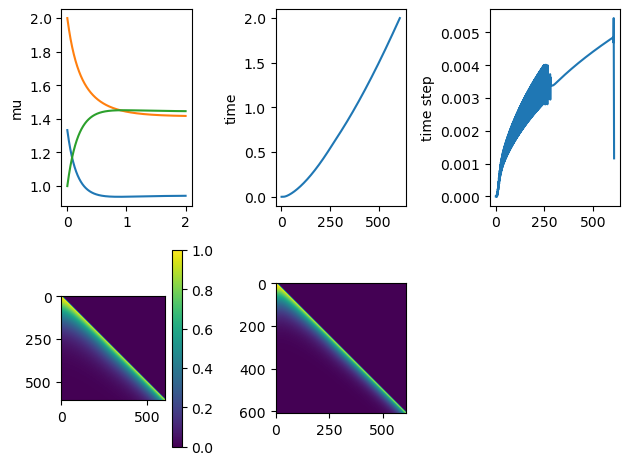

In [631]:
subplot(231)
plot(sol_SBR.t, mu_SBR[1,:])
plot(sol_SBR.t, mu_SBR[2,:])
plot(sol_SBR.t, mu_SBR[3,:])
ylabel("mu")

subplot(232)
plot(1:length(sol_SBR.t),sol_SBR.t)
ylabel("time")

subplot(233)
plot(1:length(sol_SBR.t),sol_SBR.w[length(sol_SBR.t)])
ylabel("time step")

subplot(234)
imshow(resp_gf_SBR[1,:,:])
colorbar()

subplot(235)
imshow(sigma_SBR[1,:,:])

tight_layout()

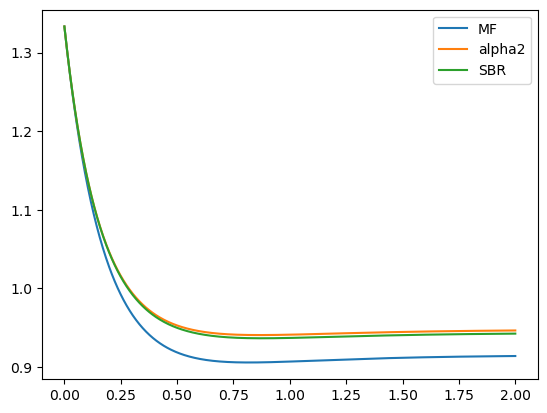

PyObject <matplotlib.legend.Legend object at 0x7f85a3323710>

In [633]:
plot(sol_MF.t, mu_MF[1,:],label="MF")
plot(sol_alpha2.t, mu_alpha2[1,:],label="alpha2")
plot(sol_SBR.t, mu_SBR[1,:],label="SBR")
legend()

## Lowering the tolerance:

In [169]:
#Initialization
dim          = num_species 
resp_gf_SBR2 = GreenFunction(zeros(Float64, dim, 1, 1), Response)
mu_SBR2      = GreenFunction(zeros(Float64, dim, 1), OnePoint)
sigma_SBR2   = zero(resp_gf_SBR2)

resp_gf_SBR2[:,1, 1] = ones(dim);
mu_SBR2[:,1]         = initial_values;

In [170]:
@time sol_SBR2 = kbsolve!(
    (x...) -> fv!(resp_gf_SBR2, mu_SBR2, sigma_SBR2, x...),
    (x...) -> fd!(resp_gf_SBR2, mu_SBR2, sigma_SBR2, x...),
    [resp_gf_SBR2],
    (0.0, tmax);
    callback = (x...) -> self_energy_SBR!(resp_gf_SBR2, mu_SBR2, sigma_SBR2, x...),
    atol = 10*atol,
    rtol = 10*rtol,
    stop = x -> (println("t: $(x[end])"); flush(stdout); false),
    v0 = [mu_SBR2,],
    f1! = (x...) -> f1!(resp_gf_SBR2, mu_SBR2, sigma_SBR2, x...)
);

t: 0.0
t: 1.0e-6
t: 5.999999999999999e-6
t: 1.7029600547039597e-5
t: 3.107746128225954e-5
t: 7.418040651154903e-5
t: 0.0001735015849228685
t: 0.00037516002426957976
t: 0.0006811061281858475
t: 0.0012381049620570025
t: 0.0020119370904716624
t: 0.0031931109281048064
t: 0.004699876816264818
t: 0.006748419302098593
t: 0.009203908744961364
t: 0.01227857151467617
t: 0.015799542381650433
t: 0.019958458254110883
t: 0.024565515250988615
t: 0.029786140082113496
t: 0.03543190185052335
t: 0.04164311776807013
t: 0.04824429971333716
t: 0.05535462236760788
t: 0.0628166308999501
t: 0.07073293064462556
t: 0.07896468812314088
t: 0.0876020967817699
t: 0.09652307175716565
t: 0.1058088063625607
t: 0.11503992910454935
t: 0.12444338328023531
t: 0.13401078422632845
t: 0.1436996700604316
t: 0.15354461355814203
t: 0.16354360207150698
t: 0.17369415108945854
t: 0.18400214993643801
t: 0.19446779668545194
t: 0.20509144219713077
t: 0.21587401861430144
t: 0.22681541406895173
t: 0.23791538024136533
t: 0.24917352086007

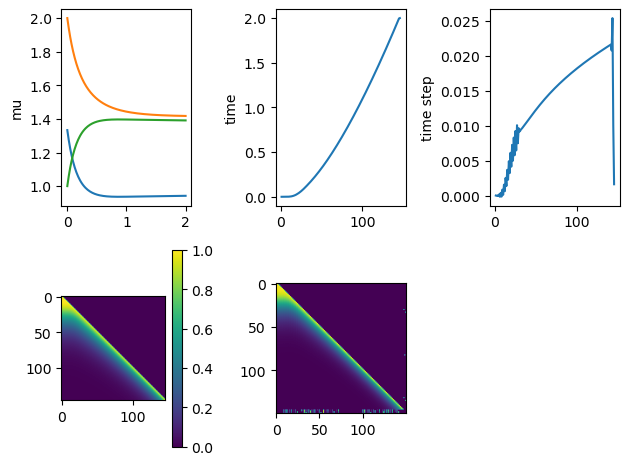

In [171]:
subplot(231)
plot(sol_SBR2.t, mu_SBR2[1,:])
plot(sol_SBR2.t, mu_SBR2[2,:])
plot(sol_SBR2.t, mu_SBR2[3,:])
ylabel("mu")

subplot(232)
plot(1:length(sol_SBR2.t),sol_SBR2.t)
ylabel("time")

subplot(233)
plot(1:length(sol_SBR2.t),sol_SBR2.w[length(sol_SBR2.t)])
ylabel("time step")

subplot(234)
imshow(resp_gf_SBR2[1,:,:])
colorbar()

subplot(235)
imshow(sigma_SBR2[1,:,:])

tight_layout()

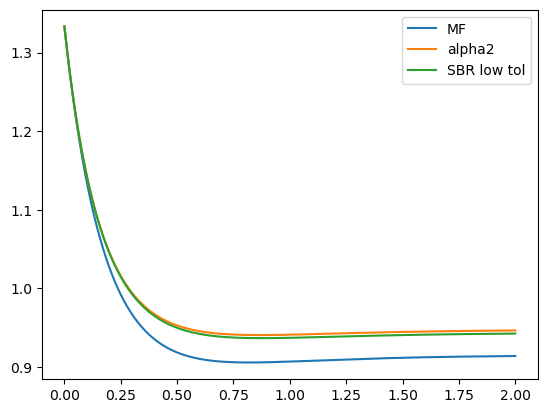

PyObject <matplotlib.legend.Legend object at 0x7f34bbe97050>

In [24]:
plot(sol_MF.t, mu_MF[1,:],label="MF")
plot(sol_alpha2.t, mu_alpha2[1,:],label="alpha2")
#plot(sol_SBR.t, mu_SBR[1,:],label="SBR")
plot(sol_SBR2.t, mu_SBR2[1,:],label="SBR low tol")
legend()

## SBR with $\Sigma$ for $\mu$ and $R$ separately: 

In [156]:
#Initialization
dim               = num_species 
resp_gf_SBR3      = GreenFunction(zeros(Float64, dim, 1, 1), Response)
mu_SBR3           = GreenFunction(zeros(Float64, dim, 1), OnePoint)
sigma_mu_SBR3     = zero(resp_gf_SBR3)
sigma_resp_SBR3   = zero(resp_gf_SBR3)


resp_gf_SBR3[:,1, 1] = ones(dim);
mu_SBR3[:,1]         = initial_values;

In [157]:
# Callback function for the self-energies
function self_energy_SBR!(resp_gf, mu, sigma_mu, sigma_R, times, h1, h2 , t, t′)
        
    # Resize self-energies when Green functions are resized    
    if (n = size(resp_gf, 2)) > size(sigma_mu, 2)
        resize!(sigma_mu, n)
        resize!(sigma_R, n)
    end
    
    id = one(sigma_mu[1,1:t,1:t])
    
    #shifted1 = circshift(resp_gf[1,1:t,1:t].*resp_gf[2,1:t,1:t],(-1,0))
    
    #Implement circshifts together later -- TODO
    
    shifted1  = resp_gf[1,1:t,1:t].*resp_gf[2,1:t,1:t]
    shifted2  = zeros(size(shifted1))
    shifted3  = zeros(size(shifted1))
    
    #print(size(mu))
    #print(size(resp_gf))
    
    for k in 1:t
        shifted2[k,1:t] = mu[1,k].*resp_gf[2,k,1:t].*h1
        shifted3[k,1:t] = mu[2,k].*resp_gf[1,k,1:t].*h1
        shifted1[k,1:t] .*= h1
    end
    
    #for k in 1:t
    #    shifted2 = circshift(mu[1,1:t].*resp_gf[2,1:t,1:t],(-1,0))
    #    shifted3 = circshift(mu[2,1:t].*resp_gf[1,1:t,1:t],(-1,0))
    #end
    
    #circshift()
    
    #for k in 1:t
        #shifted1[k,1:t] .*= h1
        #shifted2[k,1:t] .*= h1
    #end
    
    sigma_mu[1,t,t′] = ((resp_gf[1,1:t,1:t].*resp_gf[2,1:t,1:t])*inv(tril(id + k3[1].*shifted1[:,:])))[t,t′]
    sigma_mu[2,t,t′] = sigma_mu[1,t,t′]
    
    sigma_R[1,t,t′] = ((shifted2[1:t,1:t]./h1)*inv(tril(id + k3[1].*shifted2[:,:])))[t,t′]
    sigma_R[2,t,t′] = ((shifted3[1:t,1:t]./h1)*inv(tril(id + k3[1].*shifted3[:,:])))[t,t′]
    
end

self_energy_SBR! (generic function with 2 methods)

In [158]:
# Right-hand side for the "vertical" evolution
function fv!(resp_gf, mu, sigma_mu, sigma_R, out, times, h1, h2, t, t′)
    
    temp    = zero(resp_gf[t,t′])
    corr    = integrate2(h1, t, t′, sigma_R, resp_gf, mu)
    
    temp[1] = -k2[1]*resp_gf[1,t,t′] -k3[1]*mu[2,t]*resp_gf[1,t,t′]
    temp[2] = -k2[2]*resp_gf[2,t,t′] -k3[1]*mu[1,t]*resp_gf[2,t,t′]
    temp[3] = -k2[3]*resp_gf[3,t,t′]
    
    out[1]  = temp .+ k3[1]^2 .*corr
    #out[1][1] = -k2[1]*resp_gf[1,t,t′] -2*k3*mu[t]*resp_gf[t,t′] +4*k3^2*integrate2(h1, t, t′, sigma, resp_gf, mu)
    #return out
    
end

#diagonal evolution
function fd!(resp_gf, mu, sigma_mu, sigma_R, out, times, h1, h2, t, t′)
    out[1] = zero(out[1])
end

# one-time equation for condensate amplitude
function f1!(resp_gf, mu, sigma_mu, sigma_R, out, times, h1, t)
    
    temp      = zero(mu[t])
    #corr      = integrate1(h1, t, sigma_mu .+ sigma_R, mu)
    corr      = integrate1(h1, t, sigma_mu , mu)
    
    temp[1] = k1[1] .- k2[1].*mu[1,t] .-k3[1].*mu[1,t].*mu[2,t]
    temp[2] = k1[2] .- k2[2].*mu[2,t] .-k3[1].*mu[1,t].*mu[2,t]
    temp[3] = k1[3] .- k2[3].*mu[3,t] .+k3[1].*mu[1,t].*mu[2,t]
    
    out[1]    = temp .+ k3[1]^2 .*corr
    
end

f1! (generic function with 3 methods)

In [159]:
function integrate1(hs::Vector, t1, Σ::GreenFunction, μ::GreenFunction; tmax=t1)
    retval = zero(μ[t1])
    
    for k in 1:tmax
        retval[1] += Σ[1,t1,k]*μ[1,k]*μ[2,k]*hs[k]
        retval[2] += Σ[2,t1,k]*μ[1,k]*μ[2,k]*hs[k]
        retval[3] += -Σ[2,t1,k]*μ[1,k]*μ[2,k]*hs[k]
    
    end
    return retval
end

function integrate2(hs::Vector, t1, t2, Σ::GreenFunction, R::GreenFunction, μ::GreenFunction; tmax=t1)
    
    retval = zero(R[t1,t2])

    for k in t2:t1
        retval[1] += Σ[1,t1,k].*μ[2,k]*R[1,k,t2]*hs[k]
        retval[2] += Σ[2,t1,k].*μ[1,k]*R[2,k,t2]*hs[k]        
    end
    
    return retval
end

integrate2 (generic function with 1 method)

In [160]:
@time sol_SBR3 = kbsolve!(
    (x...) -> fv!(resp_gf_SBR3, mu_SBR3, sigma_mu_SBR3, sigma_resp_SBR3, x...),
    (x...) -> fd!(resp_gf_SBR3, mu_SBR3, sigma_mu_SBR3, sigma_resp_SBR3, x...),
    [resp_gf_SBR3],
    (0.0, tmax);
    callback = (x...) -> self_energy_SBR!(resp_gf_SBR3, mu_SBR3, sigma_mu_SBR3, sigma_resp_SBR3, x...),
    atol = 10*atol,
    rtol = 10*rtol,
    stop = x -> (println("t: $(x[end])"); flush(stdout); false),
    v0 = [mu_SBR3,],
    f1! = (x...) -> f1!(resp_gf_SBR3, mu_SBR3, sigma_mu_SBR3, sigma_resp_SBR3, x...)
);

t: 0.0
t: 1.0e-6
t: 5.999999999999999e-6
t: 1.7029594198676146e-5
t: 3.107745454372053e-5
t: 7.418013293108855e-5
t: 0.00017350102048607278
t: 0.000375156622138531
t: 0.0006810996686264835
t: 0.0012380699787453734
t: 0.00201185681477519
t: 0.0031928460932145403
t: 0.004699325943344774
t: 0.006747105819517196
t: 0.009201528007216452
t: 0.01227397158623661
t: 0.015792119369380946
t: 0.01994604692398957
t: 0.024547220951335758
t: 0.029758548008193896
t: 0.03539395034839715
t: 0.041590010019254074
t: 0.04817499446435483
t: 0.05526283867509456
t: 0.06270153858687863
t: 0.07058661548422612
t: 0.07878668915903543
t: 0.08738263153026578
t: 0.09596143328528532
t: 0.10473781470371904
t: 0.11370607465574928
t: 0.12281912584137172
t: 0.1321084588769918
t: 0.14157062530757672
t: 0.15120084066685655
t: 0.1610033233664248
t: 0.17097688470968614
t: 0.18112052256347833
t: 0.19143404746324755
t: 0.2019163586805471
t: 0.21256632028692124
t: 0.2233827630182512
t: 0.2343643049024154
t: 0.24550949303500194


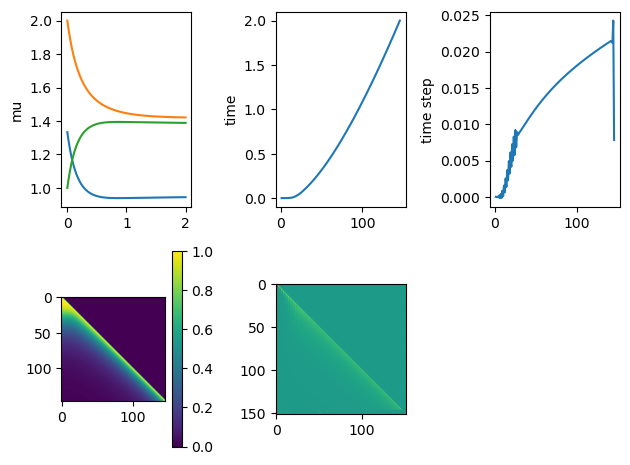

In [164]:
subplot(231)
plot(sol_SBR3.t, mu_SBR3[1,:])
plot(sol_SBR3.t, mu_SBR3[2,:])
plot(sol_SBR3.t, mu_SBR3[3,:])
ylabel("mu")

subplot(232)
plot(1:length(sol_SBR3.t),sol_SBR3.t)
ylabel("time")

subplot(233)
plot(1:length(sol_SBR3.t),sol_SBR3.w[length(sol_SBR3.t)])
ylabel("time step")

subplot(234)
imshow(resp_gf_SBR3[1,:,:])
colorbar()

subplot(235)
imshow(sigma_resp_SBR3[1,:,:])

tight_layout()

In [174]:
#touch("data/momentClosure/MM1_KM_scaleSubstrate_2/alpha_"*string(i)*".csv")
using DelimitedFiles

touch("/home/harsh/Work/code/KadanoffBaym.jl/data/AA_A_2.csv")

abc = open("/home/harsh/Work/code/KadanoffBaym.jl/data/AA_A_2.csv", "w")
mn = convert(Array,mu_SBR2[:])
    
writedlm(abc, vcat(transpose(sol_SBR2.t),transpose(mn))) 
close(abc)

## Define a structure to hold the $R, \mu, \Sigma$ etc

In [13]:
# Setting up the reactions and the parameters:

num_species     = 3 #Number of species in the reaction system
num_interaction = 1 # Number of interating reactions in the Hamiltonian
num_reactions   = 2*num_species + num_interaction # This counts the total number of possible reactions in the system.
                                        # We have 2N creation and destruction reactions and the rest interaction reactions
# k1,A = 8, k2,A = 3, k1,B =8, k2,B =2, k1,C =3, k2,C =1.5 and k3 =0.5.

# Rate constants for the reaction system: [k1 is Creation and k2 is Destruction]
k1 = [4,4,3] #len must be equal to num_species
k2 = [3,2,3] #len must be equal to num_species

k3 = [1.]

initial_values = k1./k2

s_i = [1]
r_i = [2]


1-element Vector{Int64}:
 2

In [40]:
Base.@kwdef struct reaction_structure_def{T1,T2,T3,T4}
    
    num_species::T1
    num_interactions::T1
    num_reactions::T1 = 2*num_species + num_interactions
    
    k1::T2
    k2::T2
    k3::T4
    
    s_i::T3
    r_i::T3
    
    initial_values::T4
    
end

In [80]:
ABC = reaction_structure_def(num_species=num_species,num_interactions=num_interaction,
    k1=k1,k2=k2,k3=k3,s_i=s_i,r_i=r_i,initial_values=initial_values);

In [110]:
Base.@kwdef struct reaction_variables_def{T1,T2,T3}
    
    reaction_structure::T1
    
    R::T2   = GreenFunction(zeros(Float64,reaction_structure.num_species,1,1), Response)
    μ::T3   = GreenFunction(zeros(Float64,reaction_structure.num_species,1), OnePoint)
    Σ_R::T2 = zero(R)
    Σ_μ::T2 = zero(R)
    
end

ABC_variables = reaction_variables_def(reaction_structure=ABC);

In [111]:
function initialize_reactions(rxn_structure::reaction_structure_def,rxn_variables::reaction_variables_def)
    rxn_variables.R[:,1,1] = ones(rxn_structure.num_species)
    rxn_variables.μ[:,1]   = rxn_structure.initial_values
    
end

initialize_reactions (generic function with 1 method)

In [112]:
initialize_reactions(ABC,ABC_variables);

3-element Vector{Float64}:
 1.3333333333333333
 2.0
 1.0

In [121]:
# Right-hand side for the "vertical" evolution
function fv!(rxn_variables::reaction_variables_def, rxn_structure::reaction_structure_def,
        out, times, h1, h2, t, t′)
    
    temp    = zero(rxn_variables.R[t,t′])
    corr    = integrate2(h1, t, t′, rxn_variables.Σ_R, rxn_variables.R, rxn_variables.μ)
    
    temp[1] = -rxn_structure.k2[1]*rxn_variables.R[1,t,t′] -rxn_structure.k3[1]*rxn_variables.μ[2,t]*rxn_variables.R[1,t,t′]
    temp[2] = -rxn_structure.k2[2]*rxn_variables.R[2,t,t′] -rxn_structure.k3[1]*rxn_variables.μ[1,t]*rxn_variables.R[2,t,t′]
    temp[3] = -rxn_structure.k2[3]*rxn_variables.R[3,t,t′]
    
    out[1]  = temp .+ rxn_structure.k3[1]^2 .*corr
    
end

#diagonal evolution
function fd!(rxn_variables::reaction_variables_def, rxn_structure::reaction_structure_def, out, times, h1, h2, t, t′)
    out[1] = zero(out[1])
end

# one-time equation for condensate amplitude
function f1!(rxn_variables::reaction_variables_def, rxn_structure::reaction_structure_def, out, times, h1, t)
    
    temp    = zero(rxn_variables.μ[t])
    corr    = integrate1(h1, t, rxn_variables.Σ_μ, rxn_variables.μ)
    
    temp[1] = rxn_structure.k1[1] .- rxn_structure.k2[1].*rxn_variables.μ[1,t] .-rxn_structure.k3[1].*rxn_variables.μ[1,t].*rxn_variables.μ[2,t]
    temp[2] = rxn_structure.k1[2] .- rxn_structure.k2[2].*rxn_variables.μ[2,t] .-rxn_structure.k3[1].*rxn_variables.μ[1,t].*rxn_variables.μ[2,t]
    temp[3] = rxn_structure.k1[3] .- rxn_structure.k2[3].*rxn_variables.μ[3,t] .+rxn_structure.k3[1].*rxn_variables.μ[1,t].*rxn_variables.μ[2,t]
    
    out[1]  = temp .+ rxn_structure.k3[1]^2 .*corr
    
end

f1! (generic function with 2 methods)

In [122]:
function integrate1(hs::Vector, t1, Σ::GreenFunction, μ::GreenFunction; tmax=t1)
    retval = zero(μ[t1])
    
    for k in 1:tmax
        retval[1] +=  Σ[1,t1,k]*μ[1,k]*μ[2,k]*hs[k]
        retval[2] +=  Σ[2,t1,k]*μ[1,k]*μ[2,k]*hs[k]
        retval[3] += -Σ[2,t1,k]*μ[1,k]*μ[2,k]*hs[k]
        
    end
    return retval
end

function integrate2(hs::Vector, t1, t2, Σ::GreenFunction, R::GreenFunction, μ::GreenFunction; tmax=t1)
    
    retval = zero(R[t1,t2])

    for k in t2:t1
        retval[1] += Σ[1,t1,k].*μ[2,k]*R[1,k,t2]*hs[k]
        retval[2] += Σ[2,t1,k].*μ[1,k]*R[2,k,t2]*hs[k]        
    end
    
    return retval
end

integrate2 (generic function with 1 method)

In [127]:
# Callback function for the self-energies
function self_energy!(rxn_variables::reaction_variables_def,times, h1, h2 , t, t′)
        
    # Resize self-energies when Green functions are resized    
    if (n = size(rxn_variables.R, 2)) > size(rxn_variables.Σ_R, 2)
        resize!(rxn_variables.Σ_R, n)
        resize!(rxn_variables.Σ_μ, n)
    end
    
    rxn_variables.Σ_R[1,t,t′] = (rxn_variables.R[1,:,:].*rxn_variables.R[2,:,:])[t,t′]
    rxn_variables.Σ_R[2,t,t′] = (rxn_variables.R[1,:,:].*rxn_variables.R[2,:,:])[t,t′]
    
    rxn_variables.Σ_μ[:,t,t′] = rxn_variables.Σ_R[:,t,t′]
    
end

self_energy! (generic function with 1 method)

In [128]:
@time sol_try1 = kbsolve!(
    (x...) -> fv!(ABC_variables, ABC, x...),
    (x...) -> fd!(ABC_variables, ABC, x...),
    [ABC_variables.R],
    (0.0, tmax);
    callback = (x...) -> self_energy!(ABC_variables, x...),
    atol = atol,
    rtol = rtol,
    stop = x -> (println("t: $(x[end])"); flush(stdout); false),
    v0 = [ABC_variables.μ,],
    f1! = (x...) -> f1!(ABC_variables, ABC, x...)
);

t: 0.0
t: 1.0e-6
t: 5.999999999999999e-6
t: 1.2202400187937346e-5
t: 1.8576783521097632e-5
t: 3.56039820471803e-5
t: 6.44707955843092e-5
t: 0.00011420669163182947
t: 0.00018312994924129465
t: 0.0002888870267336592
t: 0.0004244745878852649
t: 0.0006096742161205569
t: 0.0008328283610359712
t: 0.0011138322979786968
t: 0.0014372867172953352
t: 0.0018215327303525877
t: 0.002249201110119255
t: 0.002736416074615619
t: 0.0032654803435381375
t: 0.003850279109155985
t: 0.004473922194753591
t: 0.005148338883204616
t: 0.005858041468957913
t: 0.006613377175654042
t: 0.007400447954626227
t: 0.00822837799201209
t: 0.009084796578676085
t: 0.009977909519671825
t: 0.010896687622814429
t: 0.011848661496303425
t: 0.012823915891688426
t: 0.01382949400310438
t: 0.014856370750870297
t: 0.015911244221189478
t: 0.016985780869199652
t: 0.018086440355350265
t: 0.01920541430842705
t: 0.02034900344370676
t: 0.02150979018519873
t: 0.0226939753152965
t: 0.023894426042986805
t: 0.02511728696064671
t: 0.02635562773580

t: 0.9482376624783333
t: 0.9519998476488141
t: 0.9557673096799096
t: 0.9595400402471477
t: 0.9633180310613959
t: 0.9671012738689242
t: 0.9708897604514267
t: 0.9746834826260099
t: 0.9784824322451505
t: 0.982286601196629
t: 0.9860959814034413
t: 0.9899105648236928
t: 0.9937303434504761
t: 0.9975553093117367
t: 1.0013854544701275
t: 1.0052207710228525
t: 1.009061251101505
t: 1.0129068868718978
t: 1.0167576705338885
t: 1.0206135943212002
t: 1.0244746505012388
t: 1.0283408313749067
t: 1.0322121292764155
t: 1.0360885365730956
t: 1.0399700456652055
t: 1.0438566489857388
t: 1.0477483390002327
t: 1.0516451082065734
t: 1.0555469491348042
t: 1.059453854346931
t: 1.0633658164367303
t: 1.0672828280295568
t: 1.0712048817821502
t: 1.0751319703824458
t: 1.0790640865493824
t: 1.0830012230327128
t: 1.086943372612816
t: 1.0908905281005077
t: 1.0948426823368547
t: 1.0987998281929883
t: 1.1027619585699195
t: 1.1067290663983558
t: 1.1107011446385175
t: 1.1146781862799573
t: 1.1186601843413793
t: 1.122647131

In [137]:
function plot_all(rxn_variables::reaction_variables_def,solution)
    
    subplot(231)
    plot(solution.t, rxn_variables.μ[1,:])
    plot(solution.t, rxn_variables.μ[2,:])
    plot(solution.t, rxn_variables.μ[3,:])
    ylabel("mu")

    subplot(232)
    plot(1:length(solution.t),solution.t)
    ylabel("time")

    subplot(233)
    plot(1:length(solution.t),solution.w[length(solution.t)])
    ylabel("time step")

    subplot(234)
    imshow(rxn_variables.R[1,:,:])
    colorbar(shrink=0.6)
    ylabel("Resp")

    subplot(235)
    imshow(rxn_variables.Σ_R[1,:,:])
    colorbar(shrink=0.6)
    ylabel("self-energy")
    
    tight_layout()
    
end

plot_all (generic function with 1 method)

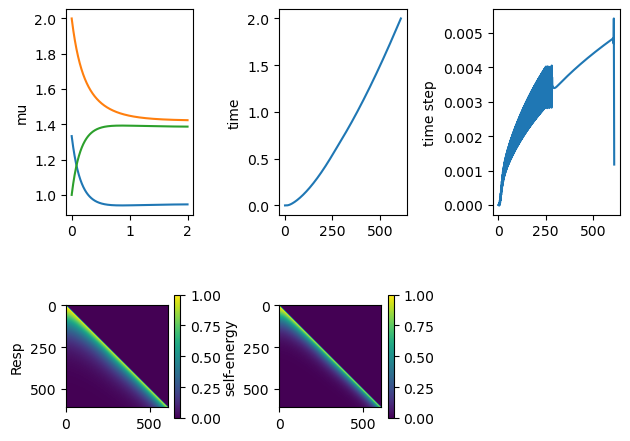

In [138]:
plot_all(ABC_variables,sol_try1)

In [143]:
# Callback function for the self-energies
function self_energy_SBR!(rxn_variables::reaction_variables_def,rxn_structure::reaction_structure_def,times, h1, h2 , t, t′)
        
    # Resize self-energies when Green functions are resized    
    if (n = size(rxn_variables.R, 2)) > size(rxn_variables.Σ_R, 2)
        resize!(rxn_variables.Σ_R, n)
        resize!(rxn_variables.Σ_μ, n)
    end
    
    id = one(rxn_variables.Σ_μ[1,1:t,1:t])
    
    #shifted1 = circshift(resp_gf[1,1:t,1:t].*resp_gf[2,1:t,1:t],(-1,0))
    
    #Implement circshifts together later -- TODO
    
    shifted1  = rxn_variables.R[1,1:t,1:t].*rxn_variables.R[2,1:t,1:t]
    shifted2  = zeros(size(shifted1))
    shifted3  = zeros(size(shifted1))
    
    #print(size(mu))
    #print(size(resp_gf))
    
    for k in 1:t
        shifted2[k,1:t] = rxn_variables.μ[1,k].*rxn_variables.R[2,k,1:t].*h1
        shifted3[k,1:t] = rxn_variables.μ[2,k].*rxn_variables.R[1,k,1:t].*h1
        shifted1[k,1:t] .*= h1
    end
    
    #for k in 1:t
    #    shifted2 = circshift(mu[1,1:t].*resp_gf[2,1:t,1:t],(-1,0))
    #    shifted3 = circshift(mu[2,1:t].*resp_gf[1,1:t,1:t],(-1,0))
    #end
    
    #circshift()
    
    #for k in 1:t
        #shifted1[k,1:t] .*= h1
        #shifted2[k,1:t] .*= h1
    #end
    
    rxn_variables.Σ_μ[1,t,t′] = ((rxn_variables.R[1,1:t,1:t].*rxn_variables.R[2,1:t,1:t])*inv(tril(id + rxn_structure.k3[1].*shifted1[:,:])))[t,t′]
    rxn_variables.Σ_μ[2,t,t′] = rxn_variables.Σ_μ[1,t,t′]
    
    rxn_variables.Σ_R[1,t,t′] = ((shifted2[1:t,1:t]./h1)*inv(tril(id + rxn_structure.k3[1].*shifted2[:,:])))[t,t′]
    rxn_variables.Σ_R[2,t,t′] = ((shifted3[1:t,1:t]./h1)*inv(tril(id + rxn_structure.k3[1].*shifted3[:,:])))[t,t′]
    
end

self_energy_SBR! (generic function with 1 method)

In [145]:
ABC_variables_SBR = reaction_variables_def(reaction_structure=ABC);
initialize_reactions(ABC,ABC_variables_SBR)

3-element Vector{Float64}:
 1.3333333333333333
 2.0
 1.0

In [146]:
@time sol_try_SBR = kbsolve!(
    (x...) -> fv!(ABC_variables_SBR, ABC, x...),
    (x...) -> fd!(ABC_variables_SBR, ABC, x...),
    [ABC_variables_SBR.R],
    (0.0, tmax);
    callback = (x...) -> self_energy_SBR!(ABC_variables_SBR, ABC, x...),
    atol = 10*atol,
    rtol = 10*rtol,
    stop = x -> (println("t: $(x[end])"); flush(stdout); false),
    v0 = [ABC_variables_SBR.μ,],
    f1! = (x...) -> f1!(ABC_variables_SBR, ABC, x...)
);

t: 0.0
t: 1.0e-6
t: 5.999999999999999e-6
t: 1.7029594198676146e-5
t: 3.107745454372053e-5
t: 7.418013293108855e-5
t: 0.00017350102048607278
t: 0.000375156622138531
t: 0.0006810996686264835
t: 0.0012380699787453734
t: 0.00201185681477519
t: 0.0031928460932145403
t: 0.004699325943344774
t: 0.006747105819517196
t: 0.009201528007216452
t: 0.01227397158623661
t: 0.015792119369380946
t: 0.01994604692398957
t: 0.024547220951335758
t: 0.029758548008193896
t: 0.03539395034839715
t: 0.041590010019254074
t: 0.04817499446435483
t: 0.05526283867509456
t: 0.06270153858687863
t: 0.07058661548422612
t: 0.07878668915903543
t: 0.08738263153026578
t: 0.09596143328528532
t: 0.10473781470371904
t: 0.11370607465574928
t: 0.12281912584137172
t: 0.1321084588769918
t: 0.14157062530757672
t: 0.15120084066685655
t: 0.1610033233664248
t: 0.17097688470968614
t: 0.18112052256347833
t: 0.19143404746324755
t: 0.2019163586805471
t: 0.21256632028692124
t: 0.2233827630182512
t: 0.2343643049024154
t: 0.24550949303500194


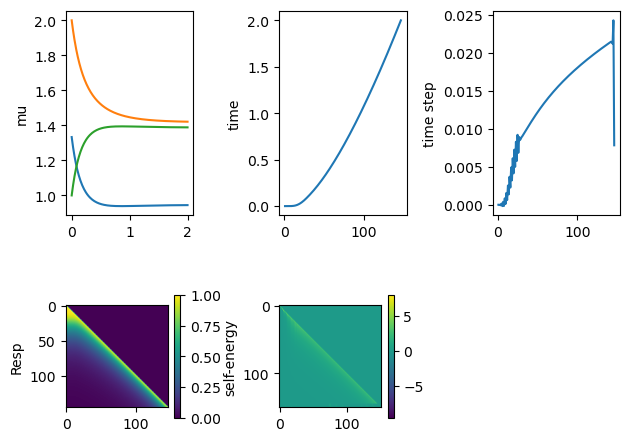

In [147]:
plot_all(ABC_variables_SBR,sol_try_SBR)

In [172]:
using Pkg
Pkg.add("Catalyst")

   Resolving package versions...
   Installed TimerOutputs ────────────── v0.5.23
   Installed Static ──────────────────── v0.8.8
   Installed DomainSets ──────────────── v0.6.7
   Installed Distances ───────────────── v0.10.9
   Installed Polyester ───────────────── v0.7.5
   Installed Unitful ─────────────────── v1.15.0
   Installed FiniteDiff ──────────────── v2.21.1
   Installed JuliaFormatter ──────────── v1.0.34
   Installed ADTypes ─────────────────── v0.1.6
   Installed SimpleNonlinearSolve ────── v0.1.18
   Installed DiffEqBase ──────────────── v6.127.0
   Installed SciMLBase ───────────────── v1.94.0
   Installed Symbolics ───────────────── v5.5.0
   Installed ThreadingUtilities ──────── v0.5.2
   Installed Catalyst ────────────────── v13.3.0
   Installed StaticArrayInterface ────── v1.4.0
   Installed CommonMark ──────────────── v0.8.12
   Installed JumpProcesses ───────────── v9.7.2
   Installed DiffRules ───────────────── v1.15.1
   Installed MLStyle ─────────────────── v0

  ✓ ExprTools
  ✓ Tricks
  ✓ UnPack
  ✓ ADTypes
  ✓ IntegerMathUtils
  ✓ CommonSolve
  ✓ Combinatorics
  ✓ ManualMemory
  ✓ LambertW
  ✓ PoissonRandom
  ✓ CompositeTypes
  ✓ SIMDTypes
  ✓ EnumX
  ✓ Distances
  ✓ IntervalSets
  ✓ AbstractTrees
  ✓ RandomExtensions
  ✓ TreeViews
  ✓ URIs
  ✓ Formatting
  ✓ Lazy
  ✓ Inflate
  ✓ Tokenize
  ✓ CpuId
  ✓ IfElse
  ✓ PackageExtensionCompat
  ✓ ConstructionBase
  ✓ Bijections
  ✓ CommonSubexpressions
  ✓ SnoopPrecompile
  ✓ SimpleTraits
  ✓ TruncatedStacktraces
  ✓ Crayons
  ✓ DiffResults
  ✓ RandomNumbers
  ✓ ZygoteRules
  ✓ FunctionWrappersWrappers
  ✓ DiffRules
  ✓ RuntimeGeneratedFunctions
  ✓ Parameters
  ✓ Primes
  ✓ TimerOutputs
  ✓ ArnoldiMethod
  ✓ ThreadingUtilities
  ✓ MultivariatePolynomials
  ✓ Latexify
  ✓ Static
  ✓ DomainSets
  ✓ Unityper
  ✓ Setfield
  ✓ CSTParser
  ✓ MLStyle
  ✓ AbstractAlgebra
  ✓ CommonMark
  ✓ BitTwiddlingConvenienceFunctions
  ✓ DynamicPolynomials
  ✓ CPUSummary
  ✓ ForwardDiff
  ✓ Graphs
  ✓ StaticArrayInt

In [173]:
Pkg.add("DifferentialEquations")
Pkg.add("Plots")

   Resolving package versions...
   Installed Sundials_jll ──────────── v5.2.1+0
   Installed CEnum ─────────────────── v0.4.2
   Installed OffsetArrays ──────────── v1.12.10
   Installed HypergeometricFunctions ─ v0.3.21
   Installed DifferentialEquations ─── v7.8.0
   Installed RecursiveArrayTools ───── v2.38.7
   Installed NonlinearSolve ────────── v1.8.0
   Installed StaticArrays ──────────── v1.6.2
   Installed BoundaryValueDiffEq ───── v2.11.0
   Installed SteadyStateDiffEq ─────── v1.16.0
   Installed SLEEFPirates ──────────── v0.6.39
   Installed SciMLNLSolve ──────────── v0.1.8
   Installed Polynomials ───────────── v3.2.13
   Installed BandedMatrices ────────── v0.17.32
   Installed MicrosoftMPI_jll ──────── v10.1.3+4
   Installed LinearSolve ───────────── v2.4.1
   Installed StaticArraysCore ──────── v1.4.2
   Installed MPIPreferences ────────── v0.1.9
   Installed SpecialFunctions ──────── v2.3.0
   Installed DiffEqNoiseProcess ────── v5.17.2
   Installed Random123 ────────

    Building HDF5 ──→ `~/.julia/scratchspaces/44cfe95a-1eb2-52ea-b672-e2afdf69b78f/c73fdc3d9da7700691848b78c61841274076932a/build.log`
    Building Conda ─→ `~/.julia/scratchspaces/44cfe95a-1eb2-52ea-b672-e2afdf69b78f/8c86e48c0db1564a1d49548d3515ced5d604c408/build.log`
    Building PyCall → `~/.julia/scratchspaces/44cfe95a-1eb2-52ea-b672-e2afdf69b78f/43d304ac6f0354755f1d60730ece8c499980f7ba/build.log`
Precompiling project...
  ✓ SimpleUnPack
  ✓ CEnum
  ✓ PositiveFactorizations
  ✓ InverseFunctions
  ✓ Compat
  ✓ OrderedCollections
  ✓ MPIPreferences
  ✓ GenericSchur
  ✓ FillArrays
  ✓ Ratios
  ✓ FastClosures
  ✓ MakieCore
  ✓ StaticArraysCore
  ✓ ArrayInterface
  ✓ GPUArraysCore
  ✓ OpenSSL_jll
  ✓ FastLapackInterface
  ✓ OffsetArrays
  ✓ ArrayInterfaceCore
  ✓ LLVMOpenMP_jll
  ✓ libaec_jll
  ✓ MicrosoftMPI_jll
  ✓ SuiteSparse_jll
  ✓ Random123
  ✓ HostCPUFeatures
  ✓ ChangesOfVariables
  ✓ DensityInterface
  ✓ Blosc_jll
  ✓ ChainRulesCore
  ✓ Parameters
  ✓ Krylov
  ✓ Latexify
  ✓ MP

Precompiling project...
  ✓ Pipe
  ✓ TensorCore
  ✓ Contour
  ✓ Measures
  ✓ ConcurrentUtilities
  ✓ SimpleBufferStream
  ✓ ExceptionUnwrapping
  ✓ Unzip
  ✓ PCRE2_jll
  ✓ BitFlags
  ✓ Scratch
  ✓ UnicodeFun
  ✓ Grisu
  ✓ TranscodingStreams
  ✓ LoggingExtras
  ✓ OpenSSL_jll
  ✓ Graphite2_jll
  ✓ Libmount_jll
  ✓ Bzip2_jll
  ✓ Xorg_libXau_jll
  ✓ libpng_jll
  ✓ libfdk_aac_jll
  ✓ LAME_jll
  ✓ Pixman_jll
  ✓ LERC_jll
  ✓ UnitfulLatexify
  ✓ fzf_jll
  ✓ JpegTurbo_jll
  ✓ XZ_jll
  ✓ Ogg_jll
  ✓ Xorg_libXdmcp_jll
  ✓ x265_jll
  ✓ x264_jll
  ✓ libaom_jll
  ✓ LZO_jll
  ✓ Opus_jll
  ✓ Expat_jll
  ✓ Xorg_xtrans_jll
  ✓ Xorg_libpthread_stubs_jll
  ✓ Libiconv_jll
  ✓ Libgpg_error_jll
  ✓ Wayland_protocols_jll
  ✓ RelocatableFolders
  ✓ Libffi_jll
  ✓ FriBidi_jll
  ✓ Libuuid_jll
  ✓ Showoff
  ✓ CodecZlib
  ✓ HDF5_jll
  ✓ FreeType2_jll
  ✓ JLFzf
  ✓ Libtiff_jll
  ✓ libvorbis_jll
  ✓ XML2_jll
  ✓ Libgcrypt_jll
  ✓ OpenSSL
  ✓ Fontconfig_jll
  ✓ Gettext_jll
  ✓ Wayland_jll
  ✓ XSLT_jll
  ✓ ColorVecto

In [174]:
using Catalyst

[ Info: Precompiling Catalyst [479239e8-5488-4da2-87a7-35f2df7eef83]
┌ Warning: Module ArrayInterface with build ID 180010065196130 is missing from the cache.
│ This may mean ArrayInterface [4fba245c-0d91-5ea0-9b3e-6abc04ee57a9] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1325
┌ Warning: Module ArrayInterface with build ID 180010065196130 is missing from the cache.
│ This may mean ArrayInterface [4fba245c-0d91-5ea0-9b3e-6abc04ee57a9] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1325
[ Info: Skipping precompilation since __precompile__(false). Importing Catalyst [479239e8-5488-4da2-87a7-35f2df7eef83].
[ Info: Precompiling DiffEqBase [2b5f629d-d688-5b77-993f-72d75c75574e]
┌ Warning: Module ArrayInterface with build ID 180010065196130 is missing from the cache.
│ This may mean ArrayInterface [4fba245c-0d91-5ea0-9b3e-6abc04ee57a9] does not support precompilation but is imported by a module that doe

┌ Warning: Module StaticArraysCore with build ID 180007379628475 is missing from the cache.
│ This may mean StaticArraysCore [1e83bf80-4336-4d27-bf5d-d5a4f845583c] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1325
┌ Warning: Module StaticArraysCore with build ID 180007379628475 is missing from the cache.
│ This may mean StaticArraysCore [1e83bf80-4336-4d27-bf5d-d5a4f845583c] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1325
[ Info: Skipping precompilation since __precompile__(false). Importing ForwardDiff [f6369f11-7733-5829-9624-2563aa707210].
[ Info: Precompiling DiffResults [163ba53b-c6d8-5494-b064-1a9d43ac40c5]
┌ Warning: Module StaticArraysCore with build ID 180007379628475 is missing from the cache.
│ This may mean StaticArraysCore [1e83bf80-4336-4d27-bf5d-d5a4f845583c] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1325
[ Info: Skipping precompi

┌ Warning: Module InverseFunctions with build ID 180094411225368 is missing from the cache.
│ This may mean InverseFunctions [3587e190-3f89-42d0-90ee-14403ec27112] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1325
[ Info: Skipping precompilation since __precompile__(false). Importing Unitful [1986cc42-f94f-5a68-af5c-568840ba703d].
[ Info: Precompiling DiffEqCallbacks [459566f4-90b8-5000-8ac3-15dfb0a30def]
┌ Warning: Module DiffEqBase with build ID 73741938701645 is missing from the cache.
│ This may mean DiffEqBase [2b5f629d-d688-5b77-993f-72d75c75574e] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1325
[ Info: Skipping precompilation since __precompile__(false). Importing DiffEqCallbacks [459566f4-90b8-5000-8ac3-15dfb0a30def].
[ Info: Precompiling NLsolve [2774e3e8-f4cf-5e23-947b-6d7e65073b56]
┌ Warning: Module ArrayInterface with build ID 180010065196130 is missing from the cache.
│ This may me

┌ Warning: Module StaticArrays with build ID 73759327318739 is missing from the cache.
│ This may mean StaticArrays [90137ffa-7385-5640-81b9-e52037218182] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1325
[ Info: Skipping precompilation since __precompile__(false). Importing DomainSets [5b8099bc-c8ec-5219-889f-1d9e522a28bf].
[ Info: Precompiling Groebner [0b43b601-686d-58a3-8a1c-6623616c7cd4]
┌ Warning: Module MultivariatePolynomials with build ID 73861419344456 is missing from the cache.
│ This may mean MultivariatePolynomials [102ac46a-7ee4-5c85-9060-abc95bfdeaa3] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1325
[ Info: Skipping precompilation since __precompile__(false). Importing Groebner [0b43b601-686d-58a3-8a1c-6623616c7cd4].
[ Info: Precompiling SimpleNonlinearSolve [727e6d20-b764-4bd8-a329-72de5adea6c7]
┌ Warning: Module FiniteDiff with build ID 73849276640856 is missing from the cache.

In [180]:
rs = @reaction_network XXX begin
  k3, 2X --> X
  k2, X --> 0
  k1, 0 --> X
end

Model XXX
States (1):
  X(t)
Parameters (3):
  k3
  k2
  k1

In [182]:
species(rs)

1-element Vector{SymbolicUtils.BasicSymbolic{Real}}:
 X(t)

In [184]:
parameters(rs)

3-element Vector{SymbolicUtils.BasicSymbolic{Real}}:
 k3
 k2
 k1

In [185]:
substoichmat(rs)

1×3 Matrix{Int64}:
 2  1  0

In [186]:
prodstoichmat(rs)

1×3 Matrix{Int64}:
 1  0  1

In [ ]:
    @species begin
        A(t)= 4.0
        B(t) = 3.0
        C(t) = 2.0
    end

In [529]:
rs_abc = @reaction_network ABC begin
    @species A(t)= 4. /3 B(t) = 2.0 C(t) = 1.0
    @parameters k1A = 4 k1B = 4 k1C = 3 k2A = 3 k2B = 2 k2C = 3 k3 = 1 k3_back = 1.2
  (k3,k3_back), A+B <--> C
  (k2A,k1A), A <--> 0
  (k2B,k1B), B <--> 0
  (k2C,k1C), C <--> 0  
end

Model ABC
States (3):
  A(t) [defaults to 1.33333]
  B(t) [defaults to 2.0]
  C(t) [defaults to 1.0]
Parameters (8):
  k1A [defaults to 4]
  k1B [defaults to 4]
  k1C [defaults to 3]
  k2A [defaults to 3]
  k2B [defaults to 2]
  k2C [defaults to 3]
⋮

In [300]:
typeof(rs_abc)

ReactionSystem{Catalyst.NetworkProperties{Int64, SymbolicUtils.BasicSymbolic{Real}}}

In [535]:
substoichmat(rs_abc)

3×8 Matrix{Int64}:
 1  0  1  0  0  0  0  0
 1  0  0  0  1  0  0  0
 0  1  0  0  0  0  1  0

In [536]:
netstoichmat(rs_abc)

3×8 Matrix{Int64}:
 -1   1  -1  1   0  0   0  0
 -1   1   0  0  -1  1   0  0
  1  -1   0  0   0  0  -1  1

In [200]:
speciesmap(rs_abc)

Dict{SymbolicUtils.BasicSymbolic{Real}, Int64} with 3 entries:
  C(t) => 3
  A(t) => 1
  B(t) => 2

In [208]:
paramsmap(rs_abc)

Dict{SymbolicUtils.BasicSymbolic{Real}, Int64} with 7 entries:
  k2B => 5
  k2A => 4
  k1B => 2
  k1A => 1
  k2C => 6
  k3  => 7
  k1C => 3

In [209]:
reactionparams(rs_abc)

7-element Vector{SymbolicUtils.BasicSymbolic{Real}}:
 k1A
 k1B
 k1C
 k2A
 k2B
 k2C
 k3

In [211]:
reactionrates(rs_abc)

7-element Vector{SymbolicUtils.BasicSymbolic{Real}}:
 k3
 k2A
 k1A
 k2B
 k1B
 k2C
 k1C

In [214]:
reactions(rs_abc)[1].rate

k3

In [222]:
osys  = convert(ODESystem, rs_abc)

Model ABC with 3 equations
States (3):
  A(t) [defaults to 1.33333]
  B(t) [defaults to 2.0]
  C(t) [defaults to 1.0]
Parameters (7):
  k1A [defaults to 4]
  k1B [defaults to 4]
  k1C [defaults to 3]
  k2A [defaults to 3]
  k2B [defaults to 2]
  k2C [defaults to 3]
⋮

In [242]:
equations(rs_abc)[2].products

SymbolicUtils.BasicSymbolic{Real}[]

In [243]:
tspan = (0,2.5)
oprob = ODEProblem(rs_abc, [], tspan, [])

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (0.0, 2.5)
u0: 3-element Vector{Float64}:
 1.3333333333333333
 2.0
 1.0

In [253]:
equations(osys)[1].rhs

k1A - k2A*A(t) - k3*A(t)*B(t)

In [257]:
# Check the Mass action flag first!
parameters(rs_abc)[1]

k1A

In [360]:
rs_abc.defaults.keys[2]

C(t)

In [285]:
get(rs_abc.defaults, "A" ,5)

5

In [287]:
numspecies(rs_abc)

3

In [294]:
Base.@kwdef struct define_reaction_variables_test2
    
    reaction_structure = false
    response_type  = "cross"
    diffusion_type = false
    
    
    if response_type == "single"
        R   = GreenFunction(zeros(Float64,numspecies(reaction_structure),1,1), Response)
        μ   = GreenFunction(zeros(Float64,numspecies(reaction_structure),1), OnePoint)
        Σ_R = zero(R)
        Σ_μ = zero(R)
        
    elseif response_type == "cross"
        R   = GreenFunction(zeros(Float64,numspecies(reaction_structure),numspecies(reaction_structure),1,1), Response)
        μ   = GreenFunction(zeros(Float64,numspecies(reaction_structure),1), OnePoint)
        Σ_R = zero(R)
    end
    
end

ABC_new = reaction_variables_test2(reaction_structure=rs_abc,response_type="cross",diffusion_type=false);

LoadError: UndefVarError: response_type not defined

In [331]:
#struct DefineReactionVariablesTest3{RS::ReactionSystem, T::Bool, S::String, GF::GreenFunction }
struct DefineReactionVariablesTest3{RS, S, T, GF}
    
    reaction_structure::RS
    response_type::S
    diffusion_type::T
    
    R::GF
    μ::GF 
    Σ_R::GF
    Σ_μ::GF
    
    function DefineReactionVariablesTest3(reaction_structure::RS, response_type::S, diffusion_type::T, RS) #where {RS, T, S, GF}
        
        if response_type == "single"
            R   = GreenFunction(zeros(Float64,numspecies(reaction_structure),1,1), Response)
            μ   = GreenFunction(zeros(Float64,numspecies(reaction_structure),1), OnePoint)
            Σ_R = zero(R)
            Σ_μ = zero(R)
            
        elseif response_type == "cross"
            R   = GreenFunction(zeros(Float64,numspecies(reaction_structure),numspecies(reaction_structure),1,1), Response)
            μ   = GreenFunction(zeros(Float64,numspecies(reaction_structure),1), OnePoint)
            Σ_R = zero(R)
            Σ_μ = zero(R)
        else
            throw(ArgumentError("Invalid response_type: $response_type"))
        end
        
        return new(reaction_structure, response_type, diffusion_type, R, μ, Σ_R, Σ_μ)
    end
end

LoadError: syntax: too few type parameters specified in "new{...}" around In[331]:2

In [333]:
#struct DefineReactionVariablesTest3{RS::ReactionSystem, T::Bool, S::String, GF::GreenFunction }
Base.@kwdef struct DefineReactionVariablesTest5{RS, T2, T3}
    
    reaction_structure::RS
 
    R::T2   = GreenFunction(zeros(Float64,numspecies(reaction_structure),numspecies(reaction_structure),1,1), Response)
    μ::T3   = GreenFunction(zeros(Float64,numspecies(reaction_structure),1), OnePoint)
    Σ::T2   = zero(R)
    
    #Add ismassaction test somehwere!
end

ABC_newvars = DefineReactionVariablesTest5(reaction_structure=rs_abc);

In [ ]:
Base.@kwdef struct reaction_structure_def{T1,T2,T3,T4}
    
    num_species::T1
    num_interactions::T1
    num_reactions::T1 = 2*num_species + num_interactions
    
    k1::T2
    k2::T2
    k3::T4
    
    s_i::T3
    r_i::T3
    
    initial_values::T4
    
end

In [343]:
# Have to define the reactions in a way that we 

for i in range(1,numreactions(rs_abc))
    temp_var_pos = 0
    temp_var_neg = 0
    temp_var_idx = 0 
    
    for j in range(1,numspecies(rs_sbc))
       if netstoichmat(rs_abc)[j,i] == 1
            temp_var_pos += 1
            temp_var_idx = j
        elseif netstoichmat(rs_abc)[j,i] == -1
            temp_var_neg += -1
            temp_var_idx = j
        end        
    end
    
    if temp_var_pos == 1 && temp_var_neg = 0
        k1[j] =  
    elseif temp_var_pos == 0 && temp_var_neg = -1
        k2[j] = 
    
end

[-1, -1, 1]
[-1, 0, 0]
[1, 0, 0]
[0, -1, 0]
[0, 1, 0]
[0, 0, -1]
[0, 0, 1]


In [380]:
dependents(reactions(rs_abc)[1],rs_abc)

2-element Vector{Any}:
 A(t)
 B(t)

In [396]:
species(rs_abc)

3-element Vector{SymbolicUtils.BasicSymbolic{Real}}:
 A(t)
 B(t)
 C(t)

In [400]:
rate(reactions(rs_abc)[1])

LoadError: MethodError: no method matching rate(::Reaction{Any, Int64})
[0mClosest candidates are:
[0m  rate([91m::Poisson[39m) at ~/.julia/packages/Distributions/DPBj4/src/univariate/discrete/poisson.jl:49
[0m  rate([91m::Exponential[39m) at ~/.julia/packages/Distributions/DPBj4/src/univariate/continuous/exponential.jl:49
[0m  rate([91m::Gamma[39m) at ~/.julia/packages/Distributions/DPBj4/src/univariate/continuous/gamma.jl:54
[0m  ...

In [368]:
reactionrates(rs_abc)

7-element Vector{SymbolicUtils.BasicSymbolic{Real}}:
 k3
 k2A
 k1A
 k2B
 k1B
 k2C
 k1C

In [407]:
rs_abc.defaults

Dict{Any, Any} with 10 entries:
  C(t) => 1.0
  k2B  => 2
  k2A  => 3
  A(t) => 1.33333
  B(t) => 2.0
  k1A  => 4
  k1B  => 4
  k2C  => 3
  k3   => 1
  k1C  => 3

In [417]:
for rxn in reactions(rs_abc)
    length(print(dependents(rxn,rs_abc),'\n'))
end

Any[A(t), B(t)]


LoadError: MethodError: no method matching length(::Nothing)
[0mClosest candidates are:
[0m  length([91m::Union{Base.KeySet, Base.ValueIterator}[39m) at abstractdict.jl:58
[0m  length([91m::Union{ZMQ._Message, Base.RefValue{ZMQ._Message}}[39m) at ~/.julia/packages/ZMQ/lrABE/src/_message.jl:31
[0m  length([91m::Union{ArrayInterface.BidiagonalIndex, ArrayInterface.TridiagonalIndex}[39m) at ~/.julia/packages/ArrayInterface/NMP3N/src/ArrayInterface.jl:812
[0m  ...

In [423]:
length(dependents(reactions(rs_abc)[5],rs_abc))

0

In [426]:
reactions(rs_abc).rates

LoadError: type Array has no field rates

In [542]:
# Morph the reaction into a more standard system

num_int        = 0
initial_values = zeros(numspecies(rs_abc))
k1             = zeros(numspecies(rs_abc))
k2             = zeros(numspecies(rs_abc))
k3             = zeros(0)
s_i            = zeros((numspecies(rs_abc),0))
r_i            = zeros((numspecies(rs_abc),0))

temp_index     = 1

for i in reactions(rs_abc)
    if length(dependents(i,rs_abc)) == 1 && length(i.products) == 0 
        #The destruction reaction
        sp     = speciesmap(rs_abc)[i.substrates[1]]
        k2[sp] = rs_abc.defaults[i.rate]
        
    elseif length(dependents(i,rs_abc)) == 0 
        #The spontaneous creation reaction
        sp     = speciesmap(rs_abc)[i.products[1]]
        k1[sp] = rs_abc.defaults[i.rate]
        
    else 
        #The interaction reactions rates
        append!(k3,rs_abc.defaults[i.rate])
        
        #For stochiometry
        s_i = cat(s_i,prodstoichmat(rs_abc)[:,temp_index],dims=2)
        r_i = cat(r_i,substoichmat(rs_abc)[:,temp_index],dims=2)
        num_int += 1
    end
    temp_index += 1
end

#Store the initial values
for i in species(rs_abc)
    sp = speciesmap(rs_abc)[i]
    initial_values[sp] = rs_abc.defaults[i]
    
end

11.2

In [546]:
typeof(resp_gf_MF)

GreenFunction{Float64, 3, Array{Float64, 3}, Response}

In [590]:
Base.@kwdef struct Define_reaction_variable
    
    R = 0 
    μ = 0
    C = 0
    Σ_R = 0
    Σ_μ = 0
    Σ_B = 0
    
end

Define_reaction_variable

In [561]:
Base.@kwdef struct Define_reaction_structure{T1,T2,T3,T4}
    
    num_species::T1 = 0
    num_interactions::T1 = 0
    num_reactions::T1 = 2*num_species + num_interactions
    
    rate_creation::T2    = zeros(0)
    rate_destruction::T2 = zeros(0)
    rate_interaction::T4 = zeros(0)
    
    stochiometry_prod::T3  = zeros(0)
    stochiometry_react::T3 = zeros(0)
    
    initial_values::T4 = zeros(0)
    
end

In [585]:
initialize_variables_test(rs_abc)

Define_reaction_variables4([0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0;;;;], [0.0; 0.0; 0.0;;], 0, 0, 0, 0)

In [586]:
function Define_reaction_structure(reaction_system::ReactionSystem,external_initialization=false)
    
    """
    TODO: Add support for external initialization
    """
    
    num_int        = 0
    initial_values = zeros(numspecies(reaction_system))
    k1             = zeros(numspecies(reaction_system))
    k2             = zeros(numspecies(reaction_system))
    k3             = zeros(0)
    s_i            = zeros((numspecies(reaction_system),0))
    r_i            = zeros((numspecies(reaction_system),0))
    temp_index     = 1

    for i in reactions(reaction_system)
        if length(dependents(i,reaction_system)) == 1 && length(i.products) == 0 
            #The destruction reaction
            sp     = speciesmap(reaction_system)[i.substrates[1]]
            k2[sp] = reaction_system.defaults[i.rate]

        elseif length(dependents(i,reaction_system)) == 0 
            #The spontaneous creation reaction
            sp     = speciesmap(reaction_system)[i.products[1]]
            k1[sp] = reaction_system.defaults[i.rate]

        else 
            #The interaction reactions rates
            append!(k3,reaction_system.defaults[i.rate])

            #For stochiometry
            s_i = cat(s_i,prodstoichmat(reaction_system)[:,temp_index],dims=2)
            r_i = cat(r_i,substoichmat(reaction_system)[:,temp_index],dims=2)
            num_int += 1
        end
        temp_index += 1
    end

    #Store the initial values
    for i in species(reaction_system)
        sp = speciesmap(reaction_system)[i]
        initial_values[sp] = reaction_system.defaults[i]

    end
    
    return Define_reaction_structure(num_species = numspecies(reaction_system),
                                            num_interactions  = num_int,
                                            rate_creation     = k1,
                                            rate_destruction  = k2,
                                            rate_interaction  = k3,
                                            stochiometry_prod = s_i,
                                            stochiometry_react= r_i,
                                            initial_values    = initial_values)
end

Define_reaction_structure

In [587]:
rs_new = Define_reaction_structure(rs_abc)

Define_reaction_structure{Int64, Vector{Float64}, Matrix{Float64}, Vector{Float64}}(3, 2, 8, [4.0, 4.0, 3.0], [3.0, 2.0, 3.0], [1.0, 1.2], [0.0 1.0; 0.0 1.0; 1.0 0.0], [1.0 0.0; 1.0 0.0; 0.0 1.0], [1.3333333333333333, 2.0, 1.0])

In [588]:
rs_new.rate_interaction

2-element Vector{Float64}:
 1.0
 1.2

In [607]:
function Define_reaction_variable(reaction_system::Define_reaction_structure,response_type="cross")
    
    if response_type == "single"
        
        R = GreenFunction(zeros(Float64,reaction_system.num_species,1,1), Response)
        R[:,:,1,1] = ones(reaction_system.num_species)
        μ = GreenFunction(zeros(Float64,reaction_system.num_species,1), OnePoint)
        μ[:,1] = reaction_system.initial_values
        
        return Define_reaction_variable( 
            R = R,
            μ = μ,
            Σ_R = GreenFunction(zeros(Float64,reaction_system.num_species,1,1), Response),
            Σ_μ = GreenFunction(zeros(Float64,reaction_system.num_species,1,1), Response))
        
    elseif response_type == "cross"
        
        R = GreenFunction(zeros(Float64,reaction_system.num_species,reaction_system.num_species,1,1), Response)
        R[:,:,1,1] = ones(reaction_system.num_species,reaction_system.num_species)
        μ = GreenFunction(zeros(Float64,reaction_system.num_species,1), OnePoint)
        μ[:,1] = reaction_system.initial_values
        
        return Define_reaction_variable( 
            R = R,
            μ = μ,
            Σ_R = GreenFunction(zeros(Float64,reaction_system.num_species,reaction_system.num_species,1,1), Response))
    end

end

Define_reaction_variable

In [608]:
rs_var = Define_reaction_variable(rs_new)

Define_reaction_variable([1.0 1.0 1.0; 1.0 1.0 1.0; 1.0 1.0 1.0;;;;], [1.3333333333333333; 2.0; 1.0;;], 0, [0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0;;;;], 0, 0)

In [609]:
rs_var.R

3×3×1×1 GreenFunction{Float64, 4, Array{Float64, 4}, Response}:
[:, :, 1, 1] =
 1.0  1.0  1.0
 1.0  1.0  1.0
 1.0  1.0  1.0

In [579]:
R   = GreenFunction(zeros(Float64,numspecies(rs_abc),1,1), Response)
μ   = GreenFunction(zeros(Float64,numspecies(rs_abc),1), OnePoint)
Σ_R = zero(R)
Σ_μ = zero(R)

3×1×1 GreenFunction{Float64, 3, Array{Float64, 3}, Response}:
[:, :, 1] =
 0.0
 0.0
 0.0

In [552]:
typeof(rs_abc)

ReactionSystem{Catalyst.NetworkProperties{Int64, SymbolicUtils.BasicSymbolic{Real}}}

In [ ]:
#How to deal with c_mns ?




In [543]:
r_i

3×2 Matrix{Float64}:
 1.0  0.0
 1.0  0.0
 0.0  1.0

In [544]:
s_i

3×2 Matrix{Float64}:
 0.0  1.0
 0.0  1.0
 1.0  0.0

In [521]:
x = zeros((2,0))
x = cat(x,[1,1],dims=2)
x = cat(x,[2,2],dims=2)

2×2 Matrix{Float64}:
 1.0  2.0
 1.0  2.0

In [440]:
rs_abc.defaults[reactions(rs_abc)[5].rate]

4

In [450]:
rs_abc.defaults[(reactions(rs_abc)[1]).products[1]]

1.0

In [455]:
(reactions(rs_abc)[1]).substrates[1]

A(t)

In [456]:
speciesmap(rs_abc)[(reactions(rs_abc)[1]).substrates[1]]

1

In [451]:
(reactions(rs_abc)[1]).substrates

2-element Vector{SymbolicUtils.BasicSymbolic{Real}}:
 A(t)
 B(t)

In [466]:
numspecies(rs_abc)

3

In [461]:
speciesmap(rs_abc)

Dict{SymbolicUtils.BasicSymbolic{Real}, Int64} with 3 entries:
  C(t) => 3
  A(t) => 1
  B(t) => 2

In [459]:
speciesmap(rs_abc)[species(rs_abc)[1]]

1

In [463]:
rs_abc.defaults[species(rs_abc)[1]]

1.3333333333333333

In [485]:
substoichmat(rs_abc)[:,1]

3-element Vector{Int64}:
 1
 1
 0

In [541]:
(reactions(rs_abc)[1]).products

1-element Vector{SymbolicUtils.BasicSymbolic{Real}}:
 C(t)